# Calculation initial feasibility of angular clustering to trace the matter distribution

## Importing packages and functions

Import packages and set up cosmology

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.special import erf

import sys
sys.path.append('../')
from scripts.luminosity_functions  import differential_comoving_volume, XrayLuminosityFunction, ClustersXrayLuminosityFunction, integrate, ldde_hasinger_soft_cutoff
from scripts.utils import set_mpl, path2plots
set_mpl()
%matplotlib inline

fiducial_params = {'Omega_c': 0.25, 'Omega_b': 0.05,
                 'h': 0.7, 'sigma8': 0.8, 'n_s': 0.96,
                 'transfer_function': 'eisenstein_hu', #eisenstein_hu_nowiggles, boltzmann_camb eisenstein_hu
                   'baryons_power_spectrum': 'nobaryons',
                   'matter_power_spectrum': 'linear'}
cosmo = ccl.Cosmology(**fiducial_params)
h = cosmo['h']

set palette to pastel
set matplotlib rc


Define effective volume for a given luminosity function, flux limits, area, redshift, photo-z parameters.

See the first formula in section 2 of the paper

In [8]:
def calc_effective_volume_photoz(cosmo: ccl.Cosmology, 
                                xlf:XrayLuminosityFunction, 
                                Slim: float = 1e-14,
                                area_deg2: float = 34.1e3,
                                z_min: float = 0.8, z_max: float = 2.0,
                                karr: np.ndarray = np.geomspace(0.01, 0.2, 50),
                                sigma_photoz: float = 0.05, z_eff_photoz: float = 1., 
                                density_multiplier: float = 1.0)  -> np.ndarray:
    """
    calc_effective_volume_photoz calulates the effective volume of the survey

    Args:
        cosmo (ccl.Cosmology): fiducial cosmology
        xlf (XrayLuminosityFunction): X-ray luminosity function to integrate (dndz, bias, etc.)
        Slim (float, optional): Limiting flux of the survey. Defaults to 1e-14.
        area_deg2 (float, optional): area of the survy in deg^2. Defaults to 34.1e3.
        z_min (float, optional): minimal rdshift. Defaults to 0.8.
        z_max (float, optional): maxumim redshift. Defaults to 2.0.
        karr (np.ndarray, optional): array of wavelength k to calculate effctiv  volume V_eff(karr). Defaults to np.geomspace(0.01, 0.2, 50), units h/Mpc
        sigma_photoz (float, optional): redshift scatter for photometric error. Defaults to 0.05.
        z_eff_photoz (float, optional): effective z on which photo-z is calculated: sigma(z) = sigma_photoz(1+z_eff_photoz). Defaults to 1..
        density_multiplier (float, optional): density multyplier for XLF. Defaults to 1.0.

    Returns:
        np.ndarray: V_eff as a function of k
    """


    zarr = np.linspace(z_min, z_max, 50)
    sigma_photoz = sigma_photoz*(1+z_eff_photoz)
    def f_photoz(k):
        if sigma_photoz == 0:
            return 1.0
        else:
            h_eff = ccl.background.h_over_h0(cosmo, 1/(1+z_eff_photoz))
            sigma_spatial = ccl.physical_constants.CLIGHT_HMPC*sigma_photoz/h_eff
            return np.sqrt(np.pi)*erf(sigma_spatial*k)/(2*sigma_spatial*k)

    def Ptr(k, z):
        return f_photoz(k*h)*ccl.linear_matter_power(cosmo, k*h, 1/(1+z))*h**3*(xlf.b_eff(np.array([z]), Slim = Slim)[1][0])**2

    def n(z):
        nh3 =  xlf.dNdz(Slim = Slim, zarr = np.array([z]), )[1][0]/differential_comoving_volume(cosmo, z)/h**3
        return nh3.value*density_multiplier

    def integrand(k, z):
        return differential_comoving_volume(cosmo, z).value*( (n(z)*Ptr(k, z)) / (n(z)*Ptr(k, z)+1))**2 * area_deg2*h**3
    @np.vectorize
    def v_eff(k):
        integrand_arr = np.array([integrand(k, zi) for zi in zarr])
        return integrate.simps(integrand_arr, zarr)
    return v_eff(karr)


### Define the tracer parameters: redshift range, luminosity function, etc

In [9]:
def_agn_xlf = XrayLuminosityFunction(xlf=ldde_hasinger_soft_cutoff,
                                     cosmo=cosmo,
                                     k_corr_po=1.9)
def_clusters_xlf = ClustersXrayLuminosityFunction(cosmo)

zmin_clu = 0.1
zmax_clu = 0.8
zmin_agn = 0.5
zmax_agn = 2.5

z_eff_photoz_agn = 1.
z_eff_photoz_clu = 0.4

fsky = 0.65
area_deg2 = 41253*fsky
karr = np.geomspace(0.01, 0.2, 35)



## Calculate the effective volume for a a given photo-z errors for both AGN and Clusters

In [10]:
sigmas = [0, 0.005, 0.01, 0.03, 0.05]

v_eff_agn_photozs = []
v_eff_clu_photozs = []

for sigma in sigmas:
    print(sigma)
    v_eff_agn_photoz = calc_effective_volume_photoz(cosmo,
                                                    def_agn_xlf,
                                                    sigma_photoz=sigma,
                                                    Slim=1e-14,
                                                    area_deg2=area_deg2,
                                                    z_min=zmin_agn, z_max=zmax_agn,
                                                    karr=karr,
                                                    z_eff_photoz=z_eff_photoz_agn,
                                                    density_multiplier=1.3)

    v_eff_clu_photoz = calc_effective_volume_photoz(cosmo,
                                                     def_clusters_xlf,
                                                     sigma_photoz=sigma,
                                                     Slim=4.4e-14,
                                                     area_deg2=area_deg2,
                                                     z_min=zmin_clu, z_max=zmax_clu,
                                                     karr=karr,
                                                     z_eff_photoz=z_eff_photoz_clu,
                                                     density_multiplier=1.0)

    v_eff_agn_photozs.append(v_eff_agn_photoz)
    v_eff_clu_photozs.append(v_eff_clu_photoz)


0
0.005
0.01
0.03
0.05


Plot the results

set palette to pastel
set matplotlib rc


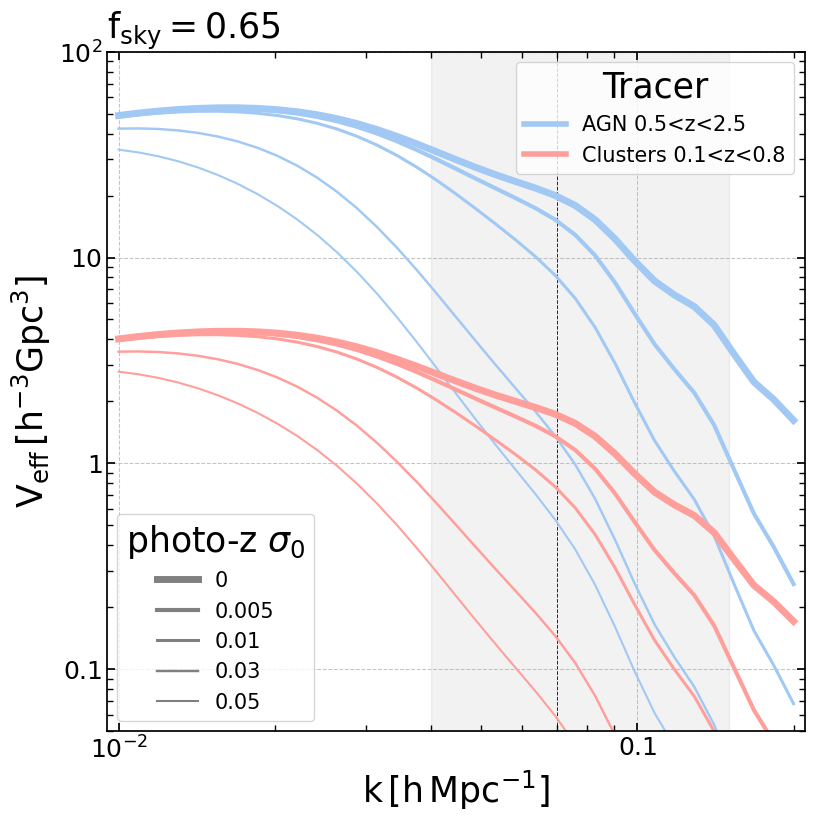

In [36]:
fig,  ax =  plt.subplots( figsize = (9,9))
set_mpl()
lss = []
for jj, sigma in enumerate(sigmas):
    l_agn,  = ax.loglog(karr, v_eff_agn_photozs[jj]/1e9, ls = '-', lw = 5/np.sqrt((jj+1)**1.5), color = 'C0', label = f'AGN {zmin_agn}<z<{zmax_agn}')
    lss.append(l_agn)

for jj, sigma in enumerate(sigmas):
    l_clu,  = ax.loglog(karr, v_eff_clu_photozs[jj]/1e9, ls = '-', lw = 5/np.sqrt((jj+1)**1.5), color = 'C3')

plt.xlabel(r'$\rm k \, [h\, Mpc^{-1}]$')
plt.ylabel(r'$\rm V_{eff} \, [ h^{-3} Gpc^3]$')
leg1 = plt.legend([l_agn, l_clu],
[f'AGN {zmin_agn}<z<{zmax_agn}', f'Clusters {zmin_clu}<z<{zmax_clu}'] ,
 loc = 'upper right', prop={'size': 15},
  title = r'Tracer', fontsize=20)

for legobj in leg1.legendHandles:
    legobj.set_linewidth(4)

leg2 = plt.legend(lss, [f"{sigma}" for sigma in sigmas], loc = 'lower left', prop={'size': 15}, title = r'photo-z $\sigma_0$', fontsize=20)
ax.add_artist(leg1)


for legobj in leg2.legendHandles:
    legobj.set_color('gray')


plt.axvline(0.07, ls = '--', color = 'k', lw = 0.7, zorder = -1)
plt.axvspan(0.04, 0.15, color = 'grey', alpha = 0.1)

plt.ylim(5e7/1e9, 1e11/1e9)
plt.xlim(0.01*0.95, 0.2*1.05)
plt.title(rf'$\rm f_{{sky}}= {fsky:.2f} $')
#plt.grid(which='major')
#plt.grid(which='both', alpha = 0.4)
plt.savefig(f'{path2plots}/effective_volume_photoz.pdf')



--------

## Additional calculations

Error on the P(k) measurements for the AGN and clusters assuming constant bins in k

set palette to pastel
set matplotlib rc


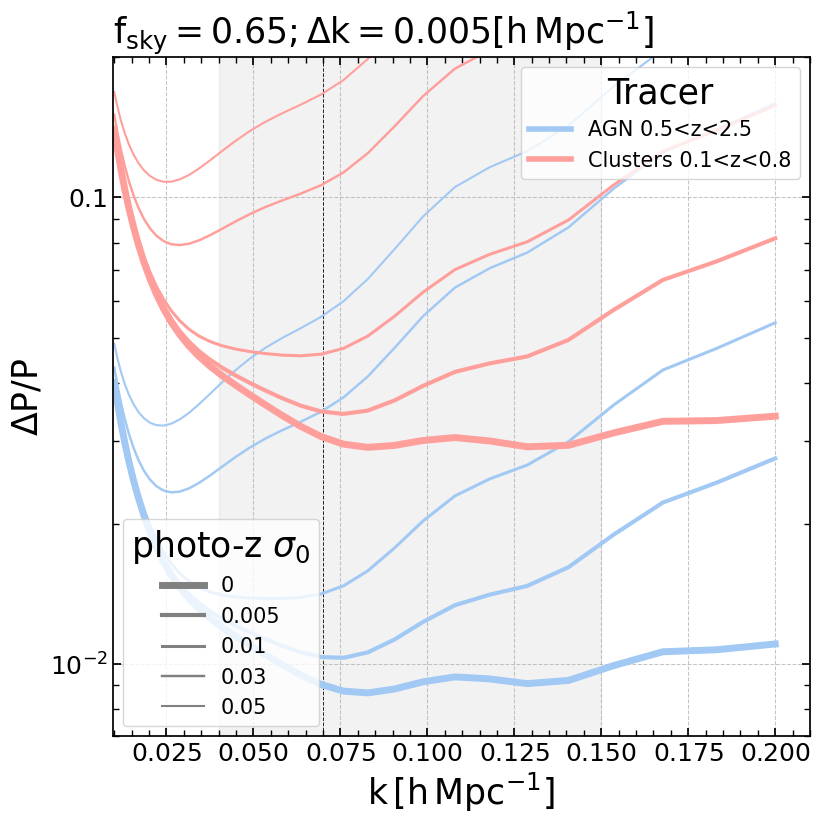

In [14]:
fig,  ax =  plt.subplots( figsize = (9,9))
set_mpl()

dk = 0.005
Vk = 4*np.pi*karr**2*dk/(2*np.pi)**3 ##hutsi 2006 formula 6 and 7
lss = []
for jj, sigma in enumerate(sigmas):
    l_agn,  = ax.semilogy(karr, np.sqrt(2/v_eff_agn_photozs[jj]/Vk), ls = '-', lw = 5/np.sqrt((jj+1)**1.5), color = 'C0', label = f'AGN {zmin_agn}<z<{zmax_agn}')
    lss.append(l_agn)

for jj, sigma in enumerate(sigmas):
    l_clu,  = ax.semilogy(karr, np.sqrt(2/v_eff_clu_photozs[jj]/Vk), ls = '-', lw = 5/np.sqrt((jj+1)**1.5), color = 'C3')

plt.xlabel(r'$\rm k \, [h\, Mpc^{-1}]$')
plt.ylabel(r'$\rm \Delta P/P$')
leg1 = plt.legend([l_agn, l_clu],
[f'AGN {zmin_agn}<z<{zmax_agn}', f'Clusters {zmin_clu}<z<{zmax_clu}'] ,
 loc = 'upper right', prop={'size': 15},
  title = r'Tracer', fontsize=20)

for legobj in leg1.legendHandles:
    legobj.set_linewidth(4)

leg2 = plt.legend(lss, [f"{sigma}" for sigma in sigmas], loc = 'lower left', prop={'size': 15}, title = r'photo-z $\sigma_0$', fontsize=20)
ax.add_artist(leg1)


for legobj in leg2.legendHandles:
    legobj.set_color('gray')


plt.axvline(0.07, ls = '--', color = 'k', lw = 0.7, zorder = -1)
plt.axvspan(0.04, 0.15, color = 'grey', alpha = 0.1)

plt.ylim(0.007, 0.2)
plt.xlim(0.01*0.95, 0.2*1.05)
plt.title(rf'$\rm f_{{sky}}= {fsky:.2f}; \Delta k = 0.005 [h\, Mpc^{{-1}}]$')

#plt.grid(which='major')
#plt.grid(which='both', alpha = 0.4)
plt.savefig(f'{path2plots}/talks/Pk_errs_photoz.pdf')



Perform calculations for the half available sky

set palette to pastel
set matplotlib rc


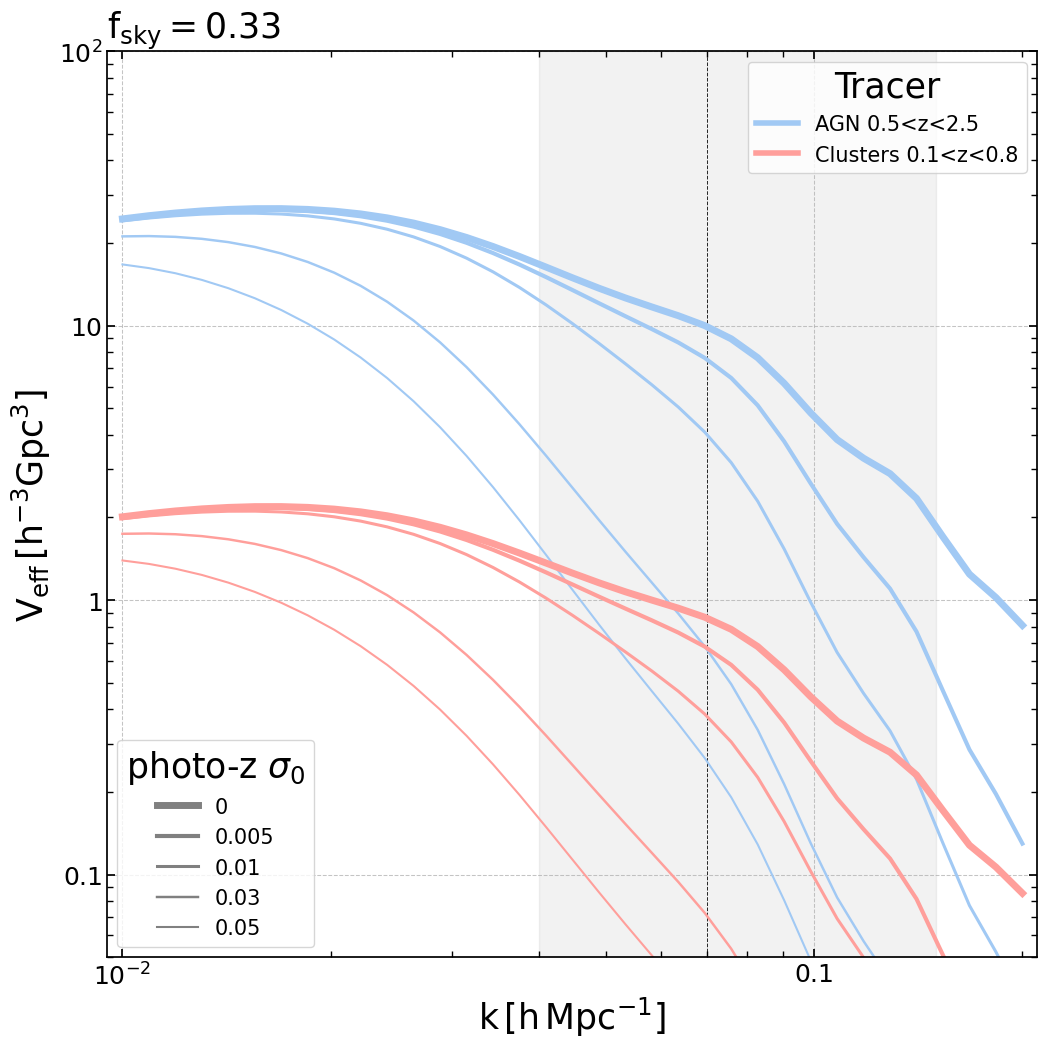

In [15]:
fig,  ax =  plt.subplots( figsize = (12,12))
set_mpl()


lss = []
for jj, sigma in enumerate(sigmas):
    l_agn,  = ax.loglog(karr, v_eff_agn_photozs[jj]/1e9/2, ls = '-', lw = 5/np.sqrt((jj+1)**1.5), color = 'C0', label = f'AGN {zmin_agn}<z<{zmax_agn}')
    lss.append(l_agn)

for jj, sigma in enumerate(sigmas):
    l_clu,  = ax.loglog(karr, v_eff_clu_photozs[jj]/1e9/2, ls = '-', lw = 5/np.sqrt((jj+1)**1.5), color = 'C3')

plt.xlabel(r'$\rm k \, [h\, Mpc^{-1}]$')
plt.ylabel(r'$\rm V_{eff} \, [ h^{-3} Gpc^3]$')
leg1 = plt.legend([l_agn, l_clu],
[f'AGN {zmin_agn}<z<{zmax_agn}', f'Clusters {zmin_clu}<z<{zmax_clu}'] ,
 loc = 'upper right', prop={'size': 15},
  title = r'Tracer', fontsize=20)

for legobj in leg1.legendHandles:
    legobj.set_linewidth(4)

leg2 = plt.legend(lss, [f"{sigma}" for sigma in sigmas], loc = 'lower left', prop={'size': 15}, title = r'photo-z $\sigma_0$', fontsize=20)
ax.add_artist(leg1)


for legobj in leg2.legendHandles:
    legobj.set_color('gray')


plt.axvline(0.07, ls = '--', color = 'k', lw = 0.7, zorder = -1)
plt.axvspan(0.04, 0.15, color = 'grey', alpha = 0.1)

plt.ylim(5e7/1e9, 1e11/1e9)
plt.xlim(0.01*0.95, 0.2*1.05)
plt.title(rf'$\rm f_{{sky}}= {fsky/2:.2f} $')
#plt.grid(which='major')
#plt.grid(which='both', alpha = 0.4)
plt.savefig(f'{path2plots}/talks/effective_volume_photoz_ru.pdf')



set palette to pastel
set matplotlib rc


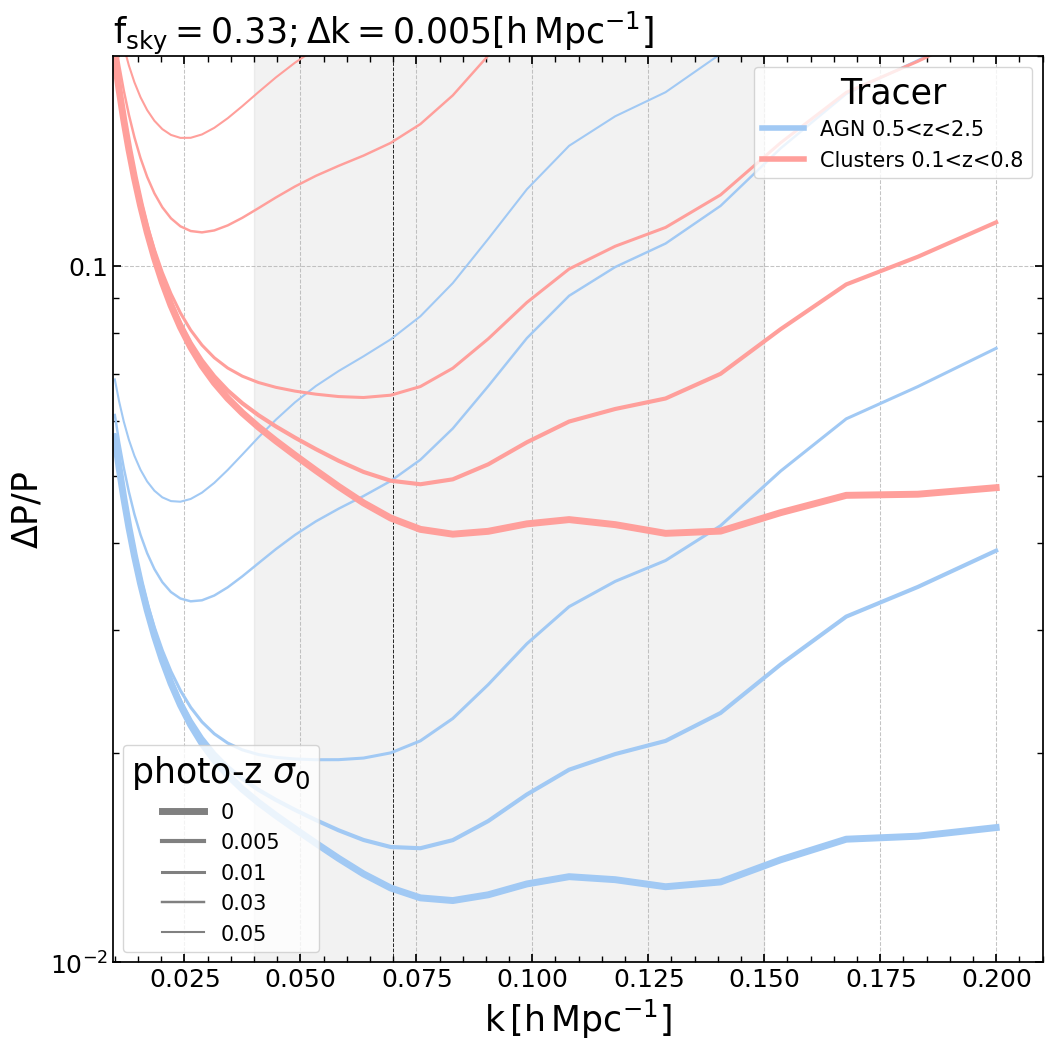

In [16]:
fig,  ax =  plt.subplots( figsize = (12,12))
set_mpl()

dk = 0.005
Vk = 4*np.pi*karr**2*dk/(2*np.pi)**3 ##hutsi 2006 formula 6 and 7
lss = []
for jj, sigma in enumerate(sigmas):
    l_agn,  = ax.semilogy(karr, np.sqrt(2*2/v_eff_agn_photozs[jj]/Vk), ls = '-', lw = 5/np.sqrt((jj+1)**1.5), color = 'C0', label = f'AGN {zmin_agn}<z<{zmax_agn}')
    lss.append(l_agn)

for jj, sigma in enumerate(sigmas):
    l_clu,  = ax.semilogy(karr, np.sqrt(2*2/v_eff_clu_photozs[jj]/Vk), ls = '-', lw = 5/np.sqrt((jj+1)**1.5), color = 'C3')

plt.xlabel(r'$\rm k \, [h\, Mpc^{-1}]$')
plt.ylabel(r'$\rm \Delta P/P$')
leg1 = plt.legend([l_agn, l_clu],
[f'AGN {zmin_agn}<z<{zmax_agn}', f'Clusters {zmin_clu}<z<{zmax_clu}'] ,
 loc = 'upper right', prop={'size': 15},
  title = r'Tracer', fontsize=20)

for legobj in leg1.legendHandles:
    legobj.set_linewidth(4)

leg2 = plt.legend(lss, [f"{sigma}" for sigma in sigmas], loc = 'lower left', prop={'size': 15}, title = r'photo-z $\sigma_0$', fontsize=20)
ax.add_artist(leg1)


for legobj in leg2.legendHandles:
    legobj.set_color('gray')


plt.axvline(0.07, ls = '--', color = 'k', lw = 0.7, zorder = -1)
plt.axvspan(0.04, 0.15, color = 'grey', alpha = 0.1)

plt.ylim(0.01, 0.2)
plt.xlim(0.01*0.95, 0.2*1.05)
plt.title(rf'$\rm f_{{sky}}= {fsky/2:.2f}; \Delta k = 0.005 [h\, Mpc^{{-1}}] $')

#plt.grid(which='major')
#plt.grid(which='both', alpha = 0.4)
plt.savefig(f'{path2plots}/talks/Pk_errs_photoz_ru.pdf')



Pk Signal per fourier mode (See Huetsi+2014)

In [17]:


def PkSNR(cosmo, xlf, Slim = 1e-14, karr = np.geomspace(0.01, 0.2, 50), sigma_photoz = 0.05, z_fid = 1.):
    sigma_photoz = sigma_photoz*(1+z_fid)
    def f_photoz(k):
        if sigma_photoz == 0:
            return 1.0
        else:
            h_eff = ccl.background.h_over_h0(cosmo, 1/(1+z_fid))
            sigma_spatial = ccl.physical_constants.CLIGHT_HMPC*sigma_photoz/h_eff
            return np.sqrt(np.pi)*erf(sigma_spatial*k)/(2*sigma_spatial*k)

    def Ptr(k, z):
        return f_photoz(k*h)*ccl.linear_matter_power(cosmo, k*h, 1/(1+z))*h**3*(xlf.b_eff(np.array([z]), Slim = Slim)[1][0])**2

    def n(z):
        nh3 =  xlf.dNdz(Slim = Slim, zarr = np.array([z]), )[1][0]/differential_comoving_volume(cosmo, z)/h**3
        return nh3.value

    def SNR(k, z_fid):
        return n(z_fid)*Ptr(k, z_fid)

    return SNR(karr, z_fid)





set palette to pastel
set matplotlib rc


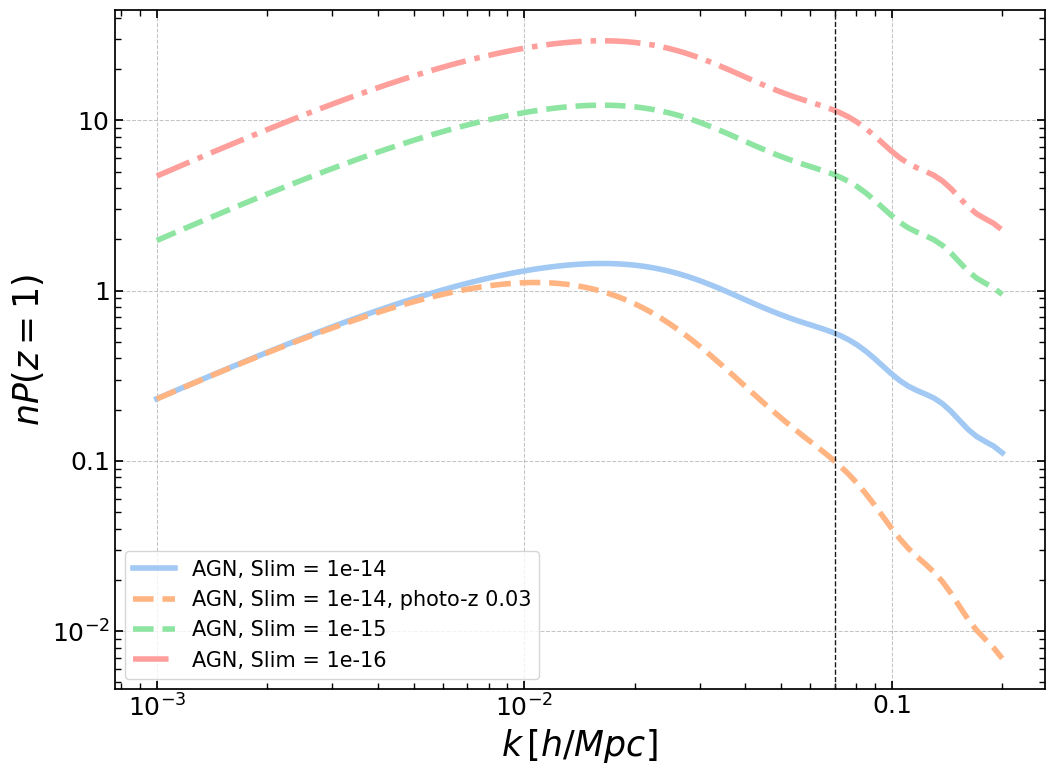

In [18]:
plt.figure(figsize = (12, 9))
karr_new = np.geomspace(0.001, 0.2, 100)
snr_agn = PkSNR(cosmo, def_agn_xlf, sigma_photoz=0, Slim = 1e-14, karr = karr_new, z_fid=1)
snr_agn_phz = PkSNR(cosmo, def_agn_xlf, sigma_photoz=0.03, Slim = 1e-14, karr = karr_new, z_fid=1)
snr_agn_2 = PkSNR(cosmo, def_agn_xlf, sigma_photoz=0, Slim = 1e-15, karr = karr_new, z_fid=1)
snr_agn_3 = PkSNR(cosmo, def_agn_xlf, sigma_photoz=0, Slim = 1e-16, karr = karr_new, z_fid=1)
set_mpl()
plt.loglog(karr_new, snr_agn, '-', lw =4, label = 'AGN, Slim = 1e-14')
plt.loglog(karr_new, snr_agn_phz, '--', lw =4, label = 'AGN, Slim = 1e-14, photo-z 0.03')
plt.loglog(karr_new, snr_agn_2, '--', lw =4, label = 'AGN, Slim = 1e-15')
plt.loglog(karr_new, snr_agn_3, '-.', lw =4, label = 'AGN, Slim = 1e-16')
plt.xlabel(r'$k \, [h/Mpc]$')
plt.ylabel(r'$nP(z=1)$')
plt.axvline(0.07, ls = '--', color = 'k', lw = 1)
plt.legend()


set palette to pastel
set matplotlib rc


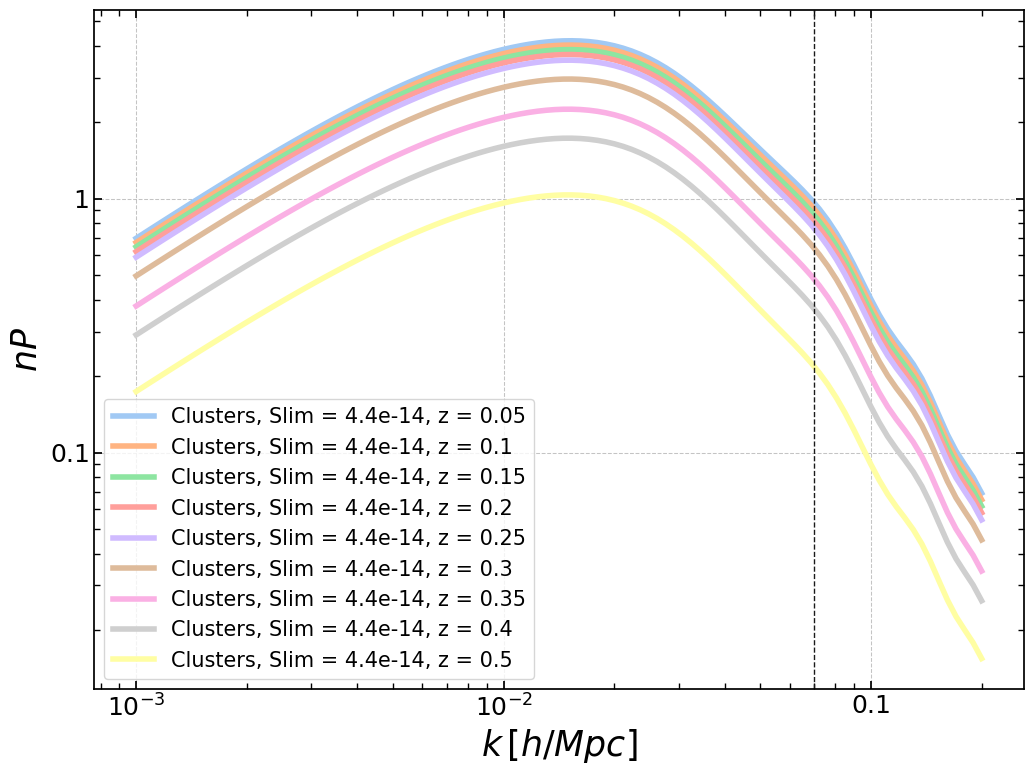

In [19]:
set_mpl()
plt.figure(figsize = (12, 9))
karr_new = np.geomspace(0.001, 0.2, 100)


for z_fid in [ 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]:
    snr_clu = PkSNR(cosmo, def_clusters_xlf, sigma_photoz=0.01, Slim = 4.4e-14, karr = karr_new, z_fid=z_fid)
    plt.loglog(karr_new, snr_clu, '-', lw =4, label = f'Clusters, Slim = 4.4e-14, z = {z_fid}')

plt.xlabel(r'$k \, [h/Mpc]$')
plt.ylabel(r'$nP$')
plt.axvline(0.07, ls = '--', color = 'k', lw = 1)
plt.legend()


set palette to pastel
set matplotlib rc


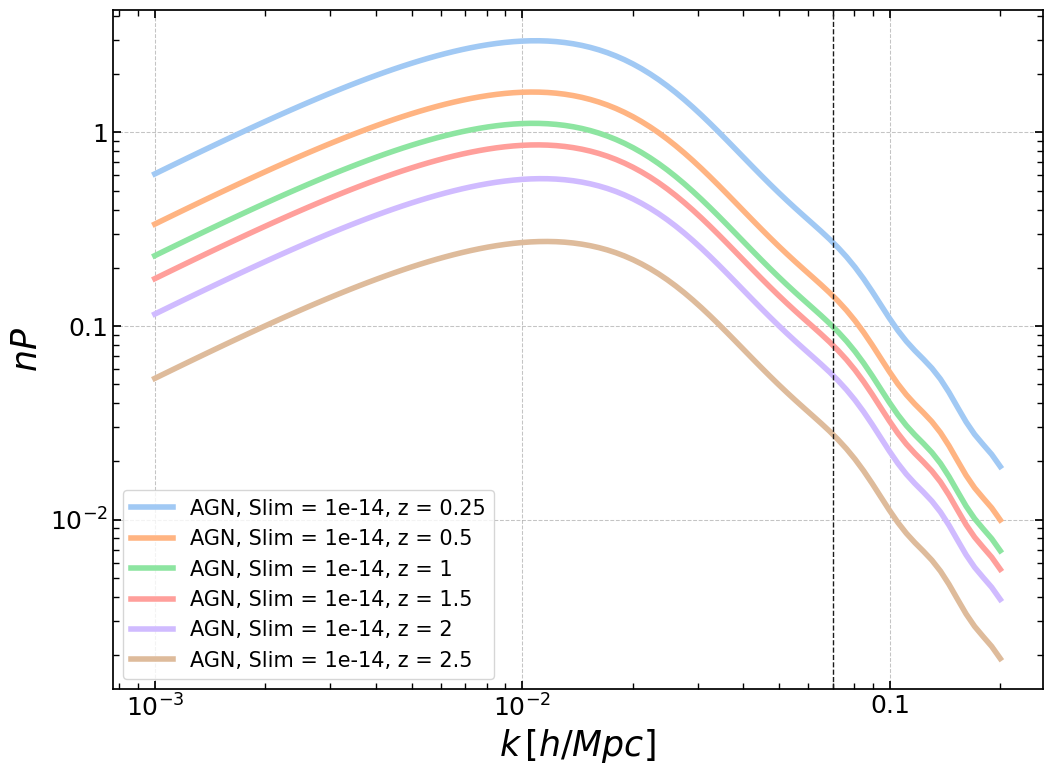

In [20]:
set_mpl()
plt.figure(figsize = (12, 9))
karr_new = np.geomspace(0.001, 0.2, 100)


for z_fid in [ 0.25, 0.5, 1, 1.5, 2, 2.5]:
    snr_clu = PkSNR(cosmo, def_agn_xlf, sigma_photoz=0.03, Slim = 1e-14, karr = karr_new, z_fid=z_fid)
    plt.loglog(karr_new, snr_clu, '-', lw =4, label = f'AGN, Slim = 1e-14, z = {z_fid}')

plt.xlabel(r'$k \, [h/Mpc]$')
plt.ylabel(r'$nP$')
plt.axvline(0.07, ls = '--', color = 'k', lw = 1)
plt.legend()
